In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
import shutil
import random
from skimage import exposure
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import BinaryFocalCrossentropy
from typing import Optional, Tuple, Union
from tensorflow.keras import Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import Regularizer
from tensorflow.keras.initializers import Initializer
from tensorflow.keras.layers import (
    Dropout,
    Rescaling,
    Conv2D,
    MaxPooling2D,
    Dense,
    GlobalAveragePooling2D,
    Add,
    BatchNormalization,
    ReLU,
    Activation,
    Flatten,
    Layer,
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import binary_focal_crossentropy, Precision, Recall, AUC
from sklearn.metrics import classification_report, roc_auc_score, f1_score, precision_recall_curve, auc, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from PIL import ImageFile, Image, ImageOps
ImageFile.LOAD_TRUNCATED_IMAGES = True


In [ ]:
def split_data(source_dir, train_dir, val_dir, test_dir, train_size=0.7, val_size=0.2):
    """
    Splits the data from the source directory into training, validation and test directories.
    The split is performed such that:
    - `train_size` fraction of the data goes to the training set
    - `val_size` fraction of the data goes to the validation set
    - The remaining data goes to the test set
    """

    # Create directories if they do not exist
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Get all the filenames from the source directory
    files = [os.path.join(source_dir, f) for f in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, f))]
    np.random.shuffle(files)  # Shuffle the files to ensure random distribution

    # Split files according to the given sizes
    train_end = int(len(files) * train_size)
    val_end = int(len(files) * (train_size + val_size))

    train_files = files[:train_end]
    val_files = files[train_end:val_end]
    test_files = files[val_end:]

    # Copy files to the respective directories
    for f in train_files:
        shutil.copy(f, os.path.join(train_dir, os.path.basename(f)))
    for f in val_files:
        shutil.copy(f, os.path.join(val_dir, os.path.basename(f)))
    for f in test_files:
        shutil.copy(f, os.path.join(test_dir, os.path.basename(f)))

    return len(train_files), len(val_files), len(test_files)



### ResNet Blocks

In [ ]:
def ResidualBlockSmall(
    x_in,
    filters: Tuple[int, int],
    s: int = 1,
    reduce: bool = False,
    kernel_regularizer: Optional[Union[Regularizer, str]] = None,
    kernel_initializer: Union[Initializer, str] = "he_uniform",
):
    """
    Create a ResNet block with 2 layers

    :param x_in: input tensor
    :param filters: number of filters in each layer
    :param s: stride used when reducing the input tensor
    :param reduce: whether to reduce the input tensor
    :param kernel_regularizer: kernel regularizer
    :param kernel_initializer: the kernel initializer to use

    :return: output tensor
    """
    filters1, filters2 = filters

    y_out = Conv2D(
        filters1,
        kernel_size=(3, 3),
        strides=(s, s),
        padding="same",
        kernel_regularizer=kernel_regularizer,
        kernel_initializer=kernel_initializer,
    )(x_in)
    y_out = BatchNormalization()(y_out)
    y_out = ReLU()(y_out)

    y_out = Conv2D(
        filters2,
        kernel_size=(3, 3),
        padding="same",
        kernel_regularizer=kernel_regularizer,
        kernel_initializer=kernel_initializer,
    )(y_out)
    y_out = BatchNormalization()(y_out)
    y_out = ReLU()(y_out)

    if reduce:
        x_in = Conv2D(
            filters2,
            kernel_size=(1, 1),
            strides=(s, s),
            kernel_regularizer=kernel_regularizer,
            kernel_initializer=kernel_initializer,
        )(x_in)
        x_in = BatchNormalization()(x_in)

    y_out = Add()([y_out, x_in])

    return ReLU()(y_out)


In [ ]:
def ResidualBlockLarge(
    x_in,
    filters: Tuple[int, int, int],
    s: int = 1,
    reduce: bool = False,
    kernel_regularizer: Optional[Union[Regularizer, str]] = None,
    kernel_initializer: Union[Initializer, str] = "he_uniform",
):
    """
    Create a ResNet block with 3 layers

    :param x_in: input tensor
    :param filters: number of filters in each layer
    :param s: stride used when reducing the input tensor
    :param reduce: whether to reduce the input tensor
    :param kernel_regularizer: kernel regularizer
    :param kernel_initializer: the kernel initializer to use

    :return: output tensor
    """
    filters1, filters2, filters3 = filters

    y_out = Conv2D(
        filters1,
        kernel_size=(1, 1),
        strides=(s, s),
        kernel_regularizer=kernel_regularizer,
        kernel_initializer=kernel_initializer,
    )(x_in)
    y_out = BatchNormalization()(y_out)
    y_out = ReLU()(y_out)

    y_out = Conv2D(
        filters2,
        kernel_size=(3, 3),
        padding="same",
        kernel_regularizer=kernel_regularizer,
        kernel_initializer=kernel_initializer,
    )(y_out)
    y_out = BatchNormalization()(y_out)
    y_out = ReLU()(y_out)

    y_out = Conv2D(
        filters3,
        kernel_size=(1, 1),
        kernel_regularizer=kernel_regularizer,
        kernel_initializer=kernel_initializer,
    )(y_out)
    y_out = BatchNormalization()(y_out)

    if reduce:
        x_in = Conv2D(
            filters3,
            kernel_size=(1, 1),
            strides=(s, s),
            kernel_regularizer=kernel_regularizer,
            kernel_initializer=kernel_initializer,
        )(x_in)
        x_in = BatchNormalization()(x_in)

    y_out = Add()([y_out, x_in])

    return ReLU()(y_out)

### ResNet Model

In [ ]:
def ResNet(
    input_shape: Tuple[int, int, int],
    block_sizes: Tuple[int, int, int, int],
    net_size: str,
    output_units: int = 1,
    include_top: bool = True,
    after_input: Optional[Union[Sequential, Layer]] = None,
    normalize: bool = False,
    kernel_regularizer: Optional[Union[Regularizer, str]] = None,
    kernel_initializer: Union[Initializer, str] = "he_uniform",
    flatten: bool = False,
    dropout_rate: float = 0.0,
) -> Model:
    """
    Create one of ResNet-18, ResNet-34, ResNet-50, ResNet-101, and ResNet-152

    :param input_shape: Shape of the input images.
    :param block_sizes: Number of layers in each block.
    :param net_size: Size of ResNet 'small' for ResNet-18 and ResNet-34, 'large' for ResNet-50, ResNet-101, and ResNet-152.
    :param output_units: Number of output units used in the last layer if include_top is True (default: 1000).
    :param include_top: Whether to include the network top after global average pooling or the flatten layer (default: True).
    :param after_input: Custom layers to add after the input like preprocessing layers as a Keras model of class
    tf.keras.Sequential or as a single layer of class tf.keras.layers.Layer (default: None - no custom layers).
    :param normalize: Whether to normalize the input images to the range [0, 1] (default: False).
    :param kernel_regularizer: Kernel regularizer of class tf.keras.regularizers.Regularizer or as a string (default: None).
    :param kernel_initializer: Kernel initializer of class tf.keras.initializers.Initializer or as a string (default: "he_uniform").
    :param flatten: Whether to use a flatten layer instead of a global average pooling layer after the last block
    (default: False - use global average pooling).
    :param dropout_rate: Dropout rate used after global average pooling or flattening (default: 0.0).

    :return: ResNet model.
    """
    if net_size not in ("small", "large"):
        raise ValueError("Invalid net_size value. Must be 'small' or 'large'.")

    x_in = Input(shape=input_shape)
    y_out = x_in

    if normalize:
        y_out = Rescaling(scale=1.0 / 255)(y_out)

    if after_input is not None:
        y_out = after_input(y_out)

    y_out = Conv2D(
        64,
        kernel_size=(7, 7),
        strides=(2, 2),
        kernel_regularizer=kernel_regularizer,
        kernel_initializer=kernel_initializer,
    )(y_out)
    y_out = BatchNormalization()(y_out)
    y_out = ReLU()(y_out)

    y_out = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(y_out)

    block1, block2, block3, block4 = block_sizes

    for layer in range(block1):
        y_out = (
            ResidualBlockLarge(
                y_out,
                (64, 64, 256),
                s=2 if layer == 0 else 1,
                reduce=layer == 0,
                kernel_regularizer=kernel_regularizer,
                kernel_initializer=kernel_initializer,
            )
            if net_size == "large"
            else ResidualBlockSmall(
                y_out,
                (64, 64),
                s=1,
                reduce=False,
                kernel_regularizer=kernel_regularizer,
                kernel_initializer=kernel_initializer,
            )
        )

    for layer in range(block2):
        y_out = (
            ResidualBlockLarge(
                y_out,
                (128, 128, 512),
                s=2 if layer == 0 else 1,
                reduce=layer == 0,
                kernel_regularizer=kernel_regularizer,
                kernel_initializer=kernel_initializer,
            )
            if net_size == "large"
            else ResidualBlockSmall(
                y_out,
                (128, 128),
                s=2 if layer == 0 else 1,
                reduce=layer == 0,
                kernel_regularizer=kernel_regularizer,
                kernel_initializer=kernel_initializer,
            )
        )

    for layer in range(block3):
        y_out = (
            ResidualBlockLarge(
                y_out,
                (256, 256, 1024),
                s=2 if layer == 0 else 1,
                reduce=layer == 0,
                kernel_regularizer=kernel_regularizer,
                kernel_initializer=kernel_initializer,
            )
            if net_size == "large"
            else ResidualBlockSmall(
                y_out,
                (256, 256),
                s=2 if layer == 0 else 1,
                reduce=layer == 0,
                kernel_regularizer=kernel_regularizer,
                kernel_initializer=kernel_initializer,
            )
        )

    for layer in range(block4):
        y_out = (
            ResidualBlockLarge(
                y_out,
                (512, 512, 2048),
                s=2 if layer == 0 else 1,
                reduce=layer == 0,
                kernel_regularizer=kernel_regularizer,
                kernel_initializer=kernel_initializer,
            )
            if net_size == "large"
            else ResidualBlockSmall(
                y_out,
                (512, 512),
                s=2 if layer == 0 else 1,
                reduce=layer == 0,
                kernel_regularizer=kernel_regularizer,
                kernel_initializer=kernel_initializer,
            )
        )

    y_out = Flatten()(y_out) if flatten else GlobalAveragePooling2D()(y_out)
    if dropout_rate > 0.0:
        y_out = Dropout(dropout_rate)(y_out)

    if include_top:
        y_out = Dense(
            output_units,
            kernel_regularizer=kernel_regularizer,
            kernel_initializer=kernel_initializer,
        )(y_out)
        y_out = Activation('sigmoid')(y_out)

    return Model(inputs=x_in, outputs=y_out)


### ResNet Variants (18, 34, 50, 101, 152)


In [ ]:
def ResNet18(
    input_shape: Tuple[int, int, int],
    output_units: int = 1,
    include_top: bool = True,
    after_input: Optional[Union[Sequential, Layer]] = None,
    normalize: bool = False,
    kernel_regularizer: Optional[Union[Regularizer, str]] = None,
    kernel_initializer: Union[Initializer, str] = "he_uniform",
    flatten: bool = False,
    dropout_rate: float = 0.0,
) -> Model:
    """
    Create a ResNet-18 model.

    :param input_shape: Shape of the input images.
    :param output_units: Number of output units used in the last layer if include_top is True (default: 1000).
    :param include_top: Whether to include the network top after global average pooling or the flatten layer (default: True).
    :param after_input: Custom layers to add after the input like preprocessing layers as a Keras model of class
    tf.keras.Sequential or as a single layer of class tf.keras.layers.Layer (default: None - no custom layers).
    :param normalize: Whether to normalize the input images to the range [0, 1] (default: False).
    :param kernel_regularizer: Kernel regularizer of class tf.keras.regularizers.Regularizer or as a string (default: None).
    :param kernel_initializer: Kernel initializer of class tf.keras.initializers.Initializer or as a string (default: "he_uniform").
    :param flatten: Whether to use a flatten layer instead of a global average pooling layer after the last block
    (default: False - use global average pooling).
    :param dropout_rate: Dropout rate used after global average pooling or flattening (default: 0.0).

    :return: ResNet-18 model.
    """
    return ResNet(
        input_shape,
        (2, 2, 2, 2),
        "small",
        output_units=output_units,
        include_top=include_top,
        after_input=after_input,
        normalize=normalize,
        kernel_regularizer=kernel_regularizer,
        kernel_initializer=kernel_initializer,
        flatten=flatten,
        dropout_rate=dropout_rate,
    )

In [ ]:
def ResNet34(
    input_shape: Tuple[int, int, int],
    output_units: int = 1,
    include_top: bool = True,
    after_input: Optional[Union[Sequential, Layer]] = None,
    normalize: bool = False,
    kernel_regularizer: Optional[Union[Regularizer, str]] = None,
    kernel_initializer: Union[Initializer, str] = "he_uniform",
    flatten: bool = False,
    dropout_rate: float = 0.0,
) -> Model:
    """
    Create a ResNet-34 model.

    :param input_shape: Shape of the input images.
    :param output_units: Number of output units used in the last layer if include_top is True (default: 1000).
    :param include_top: Whether to include the network top after global average pooling or the flatten layer (default: True).
    :param after_input: Custom layers to add after the input like preprocessing layers as a Keras model of class
    tf.keras.Sequential or as a single layer of class tf.keras.layers.Layer (default: None - no custom layers).
    :param normalize: Whether to normalize the input images to the range [0, 1] (default: False).
    :param kernel_regularizer: Kernel regularizer of class tf.keras.regularizers.Regularizer or as a string (default: None).
    :param kernel_initializer: Kernel initializer of class tf.keras.initializers.Initializer or as a string (default: "he_uniform").
    :param flatten: Whether to use a flatten layer instead of a global average pooling layer after the last block
    (default: False - use global average pooling).
    :param dropout_rate: Dropout rate used after global average pooling or flattening (default: 0.0).

    :return: ResNet-34 model.
    """
    return ResNet(
        input_shape,
        (3, 4, 6, 3),
        "small",
        output_units=output_units,
        include_top=include_top,
        after_input=after_input,
        normalize=normalize,
        kernel_regularizer=kernel_regularizer,
        kernel_initializer=kernel_initializer,
        flatten=flatten,
        dropout_rate=dropout_rate,
    )

In [ ]:
def ResNet50(
    input_shape: Tuple[int, int, int],
    output_units: int = 1,
    include_top: bool = True,
    after_input: Optional[Union[Sequential, Layer]] = None,
    normalize: bool = False,
    kernel_regularizer: Optional[Union[Regularizer, str]] = None,
    kernel_initializer: Union[Initializer, str] = "he_uniform",
    flatten: bool = False,
    dropout_rate: float = 0.0,
) -> Model:
    """
    Create a ResNet-50 model.

    :param input_shape: Shape of the input images.
    :param output_units: Number of output units used in the last layer if include_top is True (default: 1000).
    :param include_top: Whether to include the network top after global average pooling or the flatten layer (default: True).
    :param after_input: Custom layers to add after the input like preprocessing layers as a Keras model of class
    tf.keras.Sequential or as a single layer of class tf.keras.layers.Layer (default: None - no custom layers).
    :param normalize: Whether to normalize the input images to the range [0, 1] (default: False).
    :param kernel_regularizer: Kernel regularizer of class tf.keras.regularizers.Regularizer or as a string (default: None).
    :param kernel_initializer: Kernel initializer of class tf.keras.initializers.Initializer or as a string (default: "he_uniform").
    :param flatten: Whether to use a flatten layer instead of a global average pooling layer after the last block
    (default: False - use global average pooling).
    :param dropout_rate: Dropout rate used after global average pooling or flattening (default: 0.0).

    :return: ResNet-50 model.
    """
    return ResNet(
        input_shape,
        (3, 4, 6, 3),
        "large",
        output_units=output_units,
        include_top=include_top,
        after_input=after_input,
        normalize=normalize,
        kernel_regularizer=kernel_regularizer,
        kernel_initializer=kernel_initializer,
        flatten=flatten,
        dropout_rate=dropout_rate,
    )


In [ ]:

def ResNet101(
    input_shape: Tuple[int, int, int],
    output_units: int = 1,
    include_top: bool = True,
    after_input: Optional[Union[Sequential, Layer]] = None,
    normalize: bool = False,
    kernel_regularizer: Optional[Union[Regularizer, str]] = None,
    kernel_initializer: Union[Initializer, str] = "he_uniform",
    flatten: bool = False,
    dropout_rate: float = 0.0,
) -> Model:
    """
    Create a ResNet-101 model.

    :param input_shape: Shape of the input images.
    :param output_units: Number of output units used in the last layer if include_top is True (default: 1000).
    :param include_top: Whether to include the network top after global average pooling or the flatten layer (default: True).
    :param after_input: Custom layers to add after the input like preprocessing layers as a Keras model of class
    tf.keras.Sequential or as a single layer of class tf.keras.layers.Layer (default: None - no custom layers).
    :param normalize: Whether to normalize the input images to the range [0, 1] (default: False).
    :param kernel_regularizer: Kernel regularizer of class tf.keras.regularizers.Regularizer or as a string (default: None).
    :param kernel_initializer: Kernel initializer of class tf.keras.initializers.Initializer or as a string (default: "he_uniform").
    :param flatten: Whether to use a flatten layer instead of a global average pooling layer after the last block
    (default: False - use global average pooling).
    :param dropout_rate: Dropout rate used after global average pooling or flattening (default: 0.0).

    :return: ResNet-101 model.
    """
    return ResNet(
        input_shape,
        (3, 4, 23, 3),
        "large",
        output_units=output_units,
        include_top=include_top,
        after_input=after_input,
        normalize=normalize,
        kernel_regularizer=kernel_regularizer,
        kernel_initializer=kernel_initializer,
        flatten=flatten,
        dropout_rate=dropout_rate,
    )


In [ ]:
def ResNet152(
    input_shape: Tuple[int, int, int],
    output_units: int = 1,
    include_top: bool = True,
    after_input: Optional[Union[Sequential, Layer]] = None,
    normalize: bool = False,
    kernel_regularizer: Optional[Union[Regularizer, str]] = None,
    kernel_initializer: Union[Initializer, str] = "he_uniform",
    flatten: bool = False,
    dropout_rate: float = 0.0,
) -> Model:
    """
    Create a ResNet-152 model.

    :param input_shape: Shape of the input images.
    :param output_units: Number of output units used in the last layer if include_top is True (default: 1000).
    :param include_top: Whether to include the network top after global average pooling or the flatten layer (default: True).
    :param after_input: Custom layers to add after the input like preprocessing layers as a Keras model of class
    tf.keras.Sequential or as a single layer of class tf.keras.layers.Layer (default: None - no custom layers).
    :param normalize: Whether to normalize the input images to the range [0, 1] (default: False).
    :param kernel_regularizer: Kernel regularizer of class tf.keras.regularizers.Regularizer or as a string (default: None).
    :param kernel_initializer: Kernel initializer of class tf.keras.initializers.Initializer or as a string (default: "he_uniform").
    :param flatten: Whether to use a flatten layer instead of a global average pooling layer after the last block
    (default: False - use global average pooling).
    :param dropout_rate: Dropout rate used after global average pooling or flattening (default: 0.0).

    :return: ResNet-152 model.
    """
    return ResNet(
        input_shape,
        (3, 8, 36, 3),
        "large",
        output_units=output_units,
        include_top=include_top,
        after_input=after_input,
        normalize=normalize,
        kernel_regularizer=kernel_regularizer,
        kernel_initializer=kernel_initializer,
        flatten=flatten,
        dropout_rate=dropout_rate,
    )


### Main


#### Preprocessing

In [ ]:
def resize_and_pad_with_clahe(image_np, size=(224, 224), fill_color=0):
    # Convert to grayscale if it's a color image
    if image_np.ndim == 3 and image_np.shape[2] == 3:
        image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)

    # Ensure the image data type is uint8
    if image_np.dtype != np.uint8:
        image_np = (255 * image_np).astype(np.uint8)

    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    image_np = clahe.apply(image_np)

    # Convert back to PIL Image for resizing and padding
    image = Image.fromarray(image_np)

    # Resize the image, preserving aspect ratio
    image.thumbnail(size, Image.Resampling.LANCZOS)

    # Compute padding
    delta_w = size[0] - image.size[0]
    delta_h = size[1] - image.size[1]
    padding = (delta_w // 2, delta_h // 2, delta_w - (delta_w // 2), delta_h - (delta_h // 2))

    # Add padding with the appropriate fill color for grayscale
    image = ImageOps.expand(image, padding, fill=fill_color)

    # Convert back to array and duplicate channels to match the expected input shape
    image_np = np.array(image, dtype=np.float32)
    image_np = np.stack((image_np,)*3, axis=-1)  # Duplicate the single channel

    return image_np

#### Execution

In [ ]:
# Configuration
DATA_DIR = "/content/drive/MyDrive/FracAtlas/images"
TRAINING_DIR = os.path.join(DATA_DIR, "training")
TEST_DIR = os.path.join(DATA_DIR, "test")
VALIDATION_DIR = os.path.join(DATA_DIR, 'validation')
IMG_SIZE = 224
BATCH_SIZE = 28

# # Split data into train, validation, and test directories
# num_train_fracture, num_val_fracture, num_test_fracture = split_data(
#     os.path.join(DATA_DIR, "Fractured"),
#     os.path.join(TRAINING_DIR, "Fractured"),
#     os.path.join(VALIDATION_DIR, "Fractured"),
#     os.path.join(TEST_DIR, "Fractured")
# )

# num_train_non_fracture, num_val_non_fracture, num_test_non_fracture = split_data(
#     os.path.join(DATA_DIR, "Non_fractured"),
#     os.path.join(TRAINING_DIR, "Non_fractured"),
#     os.path.join(VALIDATION_DIR, "Non_fractured"),
#     os.path.join(TEST_DIR, "Non_fractured")
# )

# Load the data
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=resize_and_pad_with_clahe
)

validation_datagen = ImageDataGenerator(
    rescale=1.0/255,
    preprocessing_function=resize_and_pad_with_clahe

)
test_datagen = ImageDataGenerator(
    rescale=1.0/255,
    preprocessing_function=resize_and_pad_with_clahe
)


train_generator = train_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)



# Count the number of occurrences of each class
train_classes = train_generator.classes
train_unique, train_counts = np.unique(train_classes, return_counts=True)
train_class_counts = dict(zip(train_unique, train_counts))

print("Training class counts:", train_class_counts)


val_class_indices = validation_generator.classes
unique_val, counts_val = np.unique(val_class_indices, return_counts=True)
val_class_counts = dict(zip(unique_val, counts_val))

print("Validation Class Counts:", val_class_counts)

# For test data
test_class_indices = test_generator.classes
unique_test, counts_test = np.unique(test_class_indices, return_counts=True)
test_class_counts = dict(zip(unique_test, counts_test))

print("Test Class Counts:", test_class_counts)


Found 1153 images belonging to 2 classes.
Found 329 images belonging to 2 classes.
Found 166 images belonging to 2 classes.
Training class counts: {0: 501, 1: 652}
Validation Class Counts: {0: 143, 1: 186}
Test Class Counts: {0: 72, 1: 94}


In [ ]:
# Instantiate the ResNet model for binary classification
model = ResNet18(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    output_units=1,
    include_top=True,
    normalize=True,
    flatten=True,
    dropout_rate=0.4
    )

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=BinaryFocalCrossentropy(apply_class_balancing=True, alpha=0.75, gamma=2.0),
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc')
 ])

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes)

class_weight_dict = dict(enumerate(class_weights))

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)


# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    class_weight=class_weight_dict,
    callbacks=[reduce_lr, early_stopping, model_checkpoint]
)


# Evaluate the model on the validation set
val_scores = model.evaluate(validation_generator, steps=validation_generator.samples // BATCH_SIZE)
print("\nValidation Accuracy: %.2f%%" % (val_scores[1] * 100))

# Evaluate the model on the test set
test_scores = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)
print("\nTest Accuracy: %.2f%%" % (test_scores[1] * 100))

# Predict the validation set
Y_pred = model.predict(validation_generator, verbose=1)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = validation_generator.classes

# Classification report
print(classification_report(Y_true, Y_pred_classes))

Epoch 1/10
41/41 [==============================] - ETA: 0s - loss: 0.3718 - accuracy: 0.5316 - precision: 0.5657 - recall: 0.7323 - auc: 0.5012
Epoch 1: val_loss improved from inf to 0.07405, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 74s 1s/step - loss: 0.3718 - accuracy: 0.5316 - precision: 0.5657 - recall: 0.7323 - auc: 0.5012 - val_loss: 0.0740 - val_accuracy: 0.5649 - val_precision: 0.5649 - val_recall: 1.0000 - val_auc: 0.5619 - lr: 1.0000e-04
Epoch 2/10
41/41 [==============================] - ETA: 0s - loss: 0.3572 - accuracy: 0.5484 - precision: 0.5765 - recall: 0.7441 - auc: 0.5410
Epoch 2: val_loss did not improve from 0.07405
41/41 [==============================] - 42s 1s/step - loss: 0.3572 - accuracy: 0.5484 - precision: 0.5765 - recall: 0.7441 - auc: 0.5410 - val_loss: 0.2019 - val_accuracy: 0.5617 - val_precision: 0.5617 - val_recall: 1.0000 - val_auc: 0.4985 - lr: 1.0000e-04
Epoch 3/10
41/41 [==============================] - ETA: 0s - loss: 0.3651 - accuracy: 0.5796 - precision: 0.6020 - recall: 0.7633 - auc: 0.5585
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.

Epoch 3: val_loss did not improve from 0.07405
41/41 [===========

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# AUC-ROC Score
roc_auc = roc_auc_score(Y_true, Y_pred)
print("ROC-AUC Score:", roc_auc)

# AUC-PR Score
precision, recall, _ = precision_recall_curve(Y_true, Y_pred)
auc_pr = auc(recall, precision)
print("AUC-PR Score:", auc_pr)

# F1 Score
threshold = 0.5
Y_pred_binary = (Y_pred > threshold).astype(int)
f1 = f1_score(Y_true, Y_pred_binary)
print("F1 Score:", f1)

ROC-AUC Score: 0.5448905932776901
AUC-PR Score: 0.6123794929245955
F1 Score: 0.7223300970873786


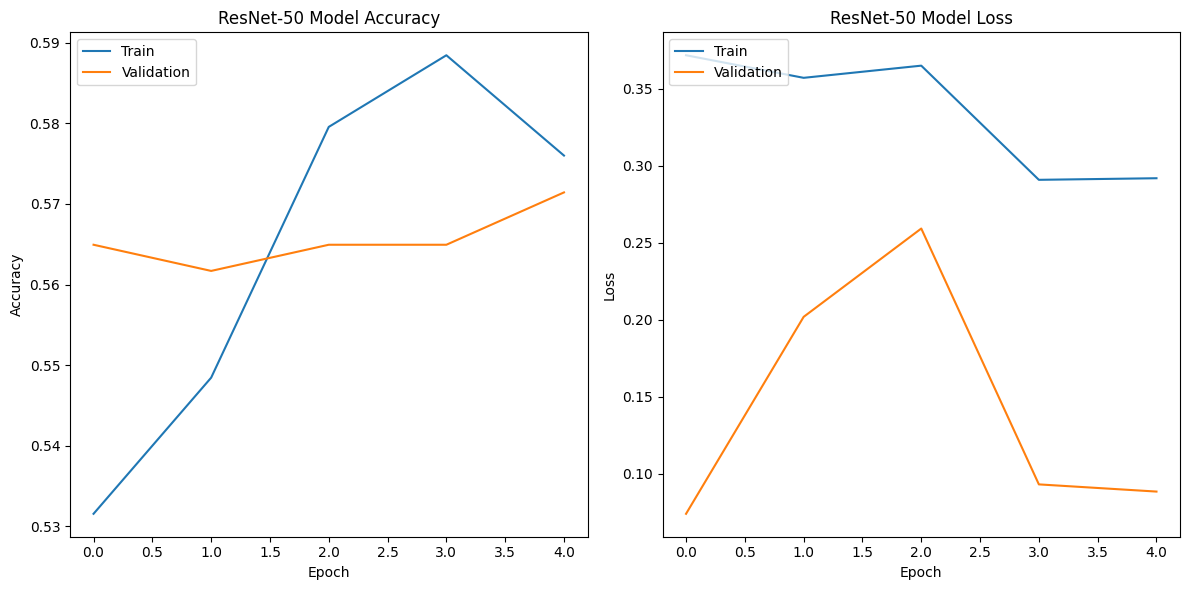

In [ ]:
import matplotlib.pyplot as plt

# Summarize history for accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ResNet-50 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('ResNet-50 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

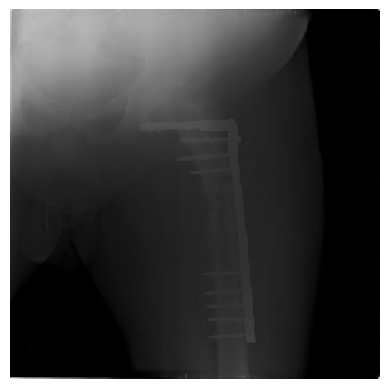

1/1 [==============================] - 0s 35ms/step
This image is predicted as: 'Fractured' with a probability of 0.5675299763679504


In [ ]:
import matplotlib.pyplot as plt
from keras.preprocessing import image
import os

# Function to load and prepare the image
def load_image(img_path, show=False):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])
        plt.axis('off')
        plt.show()

    return img_tensor

# Get image path from test set
test_img_paths = test_generator.filepaths
np.random.shuffle(test_img_paths) # Shuffle the paths to get random images
unidentified_img_path = test_img_paths[0] # Change 0 to other indices if you want to test different images

# Load and prepare the image
unidentified_img = load_image(unidentified_img_path, show=True)

# Predict the class
pred = model.predict(unidentified_img)
pred_class = np.argmax(pred, axis=1) # Use argmax to get the index of the max probability

# Map the index to the class
classes = train_generator.class_indices
predicted_class = [k for k, v in classes.items() if v == pred_class][0]

print(f"This image is predicted as: '{predicted_class}' with a probability of {pred[0][pred_class][0]}")